# _*Qiskit Aqua: Experiment with classification problem with quantum-enhanced support vector machines*_

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
Vojtech Havlicek<sup>[1]</sup>, Kristan Temme<sup>[1]</sup>, Antonio Córcoles<sup>[1]</sup>, Peng Liu<sup>[1]</sup>, Richard Chen<sup>[1]</sup>, Marco Pistoia<sup>[1]</sup> and Jay Gambetta<sup>[1]</sup>
### Affiliation
- <sup>[1]</sup>IBMQ

### Introduction
Classification algorithms and methods for machine learning are essential for pattern recognition and data mining applications. Well known techniques such as support vector machines and neural networks have blossomed over the last two decades as a result of the spectacular advances in classical hardware computational capabilities and speed. This progress in computer power made it possible to apply techniques, that were theoretically developed towards the middle of the 20th century, on classification problems that were becoming increasingly challenging.

A key concept in classification methods is that of a kernel. Data cannot typically be separated by a hyperplane in its original space. A common technique used to find such a hyperplane consists on applying a non-linear transformation function to the data. This function is called a feature map, as it transforms the raw features, or measurable properties, of the phenomenon or subject under study. Classifying in this new feature space -and, as a matter of fact, also in any other space, including the raw original one- is nothing more than seeing how close data points are to each other. This is the same as computing the inner product for each pair of data in the set. So, in fact we do not need to compute the non-linear feature map for each datum, but only the inner product of each pair of data points in the new feature space. This collection of inner products is called the kernel and it is perfectly possible to have feature maps that are hard to compute but whose kernels are not.

In this notebook we provide an example of a classification problem that requires a feature map for which computing the kernel is not efficient classically -this means that the required computational resources are expected to scale exponentially with the size of the problem. We show how this can be solved in a quantum processor by a direct estimation of the kernel in the feature space. The method we used falls in the category of what is called supervised learning, consisting of a training phase (where the kernel is calculated and the support vectors obtained) and a test or classification phase (where new unlabelled data is classified according to the solution found in the training phase).

References and additional details:

[1] Vojtech Havlicek, Antonio D. C´orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta1, "Supervised learning with quantum enhanced feature spaces," [arXiv: 1804.11326](https://arxiv.org/pdf/1804.11326.pdf)

In [3]:
from qsvm_datasets import *

from qiskit import BasicAer
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import QSVM
from qiskit.aqua.components.feature_maps import SecondOrderExpansion

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

### [Optional] Setup token to run the experiment on a real device
If you would like to run the experiement on a real device, you need to setup your account first.

Note: If you do not store your token yet, use `IBMQ.save_accounts()` to store it first.

In [4]:
#from qiskit import IBMQ
#IBMQ.load_accounts()

First we prepare the dataset, which is used for training, testing and the finally prediction.

*Note: You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.*

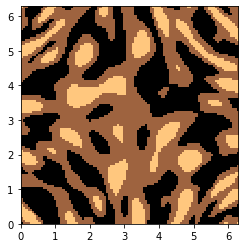

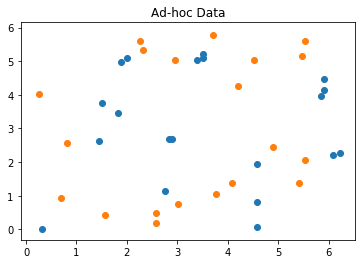

{'A': 0, 'B': 1}


In [5]:
feature_dim=2 # we support feature_dim 2 or 3
sample_Total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=20, 
    test_size=10, 
    n=feature_dim, 
    gap=0.3, 
    PLOT_DATA=True
)
extra_test_data = sample_ad_hoc_data(sample_Total, 10, n=feature_dim)
datapoints, class_to_label = split_dataset_to_data_and_labels(extra_test_data)
print(class_to_label)

With the dataset ready we initialize the necessary inputs for the algorithm:
- the input dictionary (params) 
- the input object containing the dataset info (algo_input).

With everything setup, we can now run the algorithm.

For the testing, the result includes the details and the success ratio.

For the prediction, the result includes the predicted labels. 

In [6]:
seed = 10598

feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input, datapoints[0])

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

"""declarative approach
params = {
    'problem': {'name': 'classification', 'random_seed': 10598},
    'algorithm': {
        'name': 'QSVM'
    },
    'backend': {'provider': 'qiskit.BasicAer', 'name': 'qasm_simulator', 'shots': 1024},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entanglement': 'linear'}
}
algo_input = ClassificationInput(training_input, test_input, datapoints[0])
result = run_algorithm(params, algo_input)
"""

print("testing success ratio: {}".format(result['testing_accuracy']))
print("preduction of datapoints:")
print("ground truth: {}".format(map_label_to_class_name(datapoints[1], qsvm.label_to_class)))
print("prediction:   {}".format(result['predicted_classes']))

testing success ratio: 1.0
preduction of datapoints:
ground truth: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
prediction:   ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']


kernel matrix during the training:


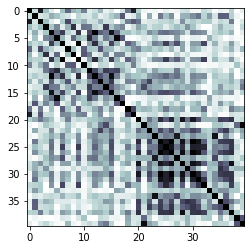

In [7]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

### The breast cancer dataset
Now we run our algorithm with the real-world dataset: the breast cancer dataset, we use the first two principal components as features.

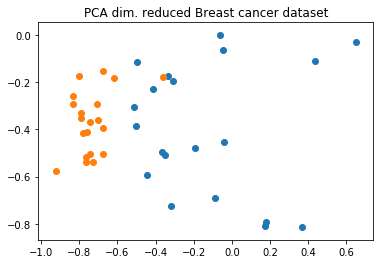

In [8]:
sample_Total, training_input, test_input, class_labels = Breast_cancer(
    training_size=20,
    test_size=10,
    n=2,
    PLOT_DATA=True
)

In [9]:
seed = 10598

feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_transpiler=seed)

result = qsvm.run(quantum_instance)

"""declarative approach, re-use the params above
algo_input = ClassificationInput(training_input, test_input)
result = run_algorithm(params, algo_input)
"""
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.9


kernel matrix during the training:


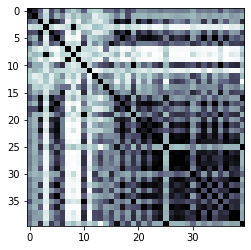

In [10]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()